In [1]:
import sys
import os
base_dir = os.path.abspath(".")
sys.path.append(base_dir)

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as PILImage
import cv2


from utils import *
from models.CtRNet import CtRNet



# Panda

In [2]:
import argparse
parser = argparse.ArgumentParser()

args = parser.parse_args("")

args.base_dir = "/home/jingpei/Desktop/CtRNet-robot-pose-estimation"
args.use_gpu = True
args.evaluate = True
args.trained_on_multi_gpus = True
args.keypoint_seg_model_path = os.path.join(args.base_dir,"weights/panda/panda-3cam_azure/net.pth")
args.urdf_file = os.path.join(args.base_dir,"urdfs/Panda/panda.urdf")

args.robot_name = 'Panda' # "Panda" or "Baxter_left_arm"
args.n_kp = 7
args.scale = 0.5
args.height = 480
args.width = 640
args.fx, args.fy, args.px, args.py = 399.6578776041667, 399.4959309895833, 319.8955891927083, 244.0602823893229

# scale the camera parameters
args.width = int(args.width * args.scale)
args.height = int(args.height * args.scale)
args.fx = args.fx * args.scale
args.fy = args.fy * args.scale
args.px = args.px * args.scale
args.py = args.py * args.scale

In [3]:
trans_to_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def preprocess_img(cv_img,args):
    image_pil = PILImage.fromarray(cv_img)
    width, height = image_pil.size
    new_size = (int(width*args.scale),int(height*args.scale))
    image_pil = image_pil.resize(new_size)
    image = trans_to_tensor(image_pil)
    return image

In [4]:
CtRNet = CtRNet(args)

Loading keypoint segmentation model from /home/jingpei/Desktop/CtRNet-robot-pose-estimation/weights/panda/panda-3cam_azure/net.pth


In [5]:
cv_img = cv2.imread(os.path.join(args.base_dir,"images/panda.jpg"))
cv_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
image = preprocess_img(cv_img,args)
if args.use_gpu:
    image = image.cuda()

joint_angles = np.array([ 0.0200, -0.9641, -0.0662, -2.7979, -0.0469,  1.9289,  0.9137])

In [6]:
cTr, points_2d, segmentation = CtRNet.inference_single_image(image, joint_angles)
print(CtRNet.cTr_to_pose_matrix(cTr))


tensor([[[ 0.8575,  0.5139, -0.0044, -0.1976],
         [ 0.0952, -0.1674, -0.9811,  0.3963],
         [-0.5050,  0.8412, -0.1925,  1.0495],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]], device='cuda:0',
       grad_fn=<CopySlices>)


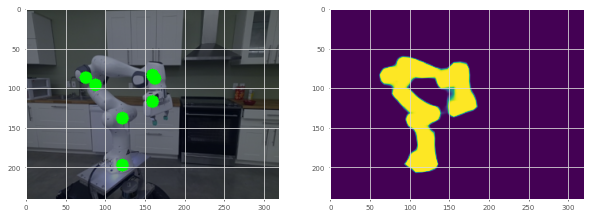

In [7]:
img_np = to_numpy_img(image)
img_np = 0.0* np.ones(img_np.shape) + img_np * 0.6
img_np = overwrite_image(img_np,points_2d.detach().cpu().numpy().squeeze().astype(int), color=(0,1,0))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img_np)
plt.subplot(1,2,2)
plt.imshow(segmentation[0].squeeze().detach().cpu().numpy())
plt.show()

# Baxter

In [2]:
import argparse
parser = argparse.ArgumentParser()

args = parser.parse_args("")

args.base_dir = "/home/jingpei/Desktop/CtRNet-robot-pose-estimation"
args.use_gpu = True
args.evaluate = True
args.trained_on_multi_gpus = False
args.keypoint_seg_model_path = os.path.join(args.base_dir,"weights/baxter/net.pth")
args.urdf_file = os.path.join(args.base_dir,"urdfs/Baxter/baxter_description/urdf/baxter.urdf")

args.robot_name = 'Baxter_left_arm' # "Panda" or "Baxter_left_arm"
args.n_kp = 7
args.scale = 0.3125
args.height = 1536
args.width = 2048
args.fx, args.fy, args.px, args.py = 960.41357421875, 960.22314453125, 1021.7171020507812, 776.2381591796875

# scale the camera parameters
args.width = int(args.width * args.scale)
args.height = int(args.height * args.scale)
args.fx = args.fx * args.scale
args.fy = args.fy * args.scale
args.px = args.px * args.scale
args.py = args.py * args.scale

In [3]:
CtRNet = CtRNet(args)

Loading keypoint segmentation model from /home/jingpei/Desktop/CtRNet-robot-pose-estimation/weights/baxter/net.pth


In [4]:
trans_to_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def preprocess_img(cv_img,args):
    image_pil = PILImage.fromarray(cv_img)
    width, height = image_pil.size
    new_size = (int(width*args.scale),int(height*args.scale))
    image_pil = image_pil.resize(new_size)
    image = trans_to_tensor(image_pil)
    return image

In [5]:
cv_img = cv2.imread(os.path.join(args.base_dir,"images/baxter.png"))
cv_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
image = preprocess_img(cv_img,args)
if args.use_gpu:
    image = image.cuda()


joint_angles = np.array([ 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.8000])

In [6]:
cTr, points_2d, segmentation = CtRNet.inference_single_image(image, joint_angles)
print(CtRNet.cTr_to_pose_matrix(cTr))

tensor([[[ 0.9125,  0.4103,  0.0022, -0.5949],
         [-0.0446,  0.1049, -0.9938,  0.1592],
         [-0.4079,  0.9062,  0.1140,  1.1780],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]], device='cuda:0',
       grad_fn=<CopySlices>)


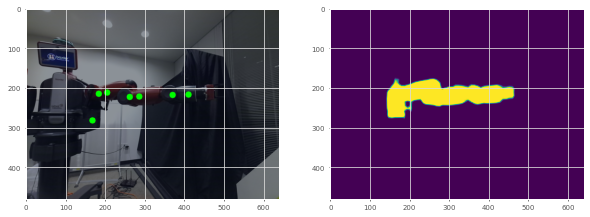

In [7]:
img_np = to_numpy_img(image)
img_np = 0.0* np.ones(img_np.shape) + img_np * 0.6
img_np = overwrite_image(img_np,points_2d.detach().cpu().numpy().squeeze().astype(int), color=(0,1,0))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img_np)
plt.subplot(1,2,2)
plt.imshow(segmentation[0].squeeze().detach().cpu().numpy())
plt.show()